In [1]:
! pip install datasets transformers
! pip install accelerate -U
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import cv2
import datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from datasets import load_dataset
ham_path = "drive/MyDrive/data"
ds = load_dataset("imagefolder", data_dir=ham_path)

Resolving data files:   0%|          | 0/1792 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1792
    })
})

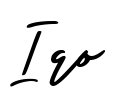

In [6]:
example = ds['train'][1000]
example['image']

In [7]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['AguafinaScript', 'AlexBrush', 'Allura', 'Canterbury', 'GreatVibes', 'Holligate Signature', 'I Love Glitter', 'James Fajardo', 'OpenSans', 'alsscrp'], id=None)

In [14]:
data_ds = ds['train'].train_test_split(shuffle = True, seed = 0, test_size=0.3)
data_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1254
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 538
    })
})

In [19]:
data_test_ds = data_ds['test'].train_test_split(shuffle = True, seed = 0, test_size=0.5)
data_test_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
})

In [20]:
from datasets import DatasetDict
final_dataset = DatasetDict({
    'train': data_ds['train'],
    'validation': data_test_ds['train'],
    'test': data_test_ds['test']
})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1254
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
})

In [ ]:
# data_ds = ds['train'].train_test_split(0.2, seed=0)

In [21]:
from transformers import ViTFeatureExtractor, AutoImageProcessor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [22]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = final_dataset.with_transform(transform)

In [23]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1254
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
})

In [24]:
import torch
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [25]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-25-0dee3e477be2>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [26]:
from transformers import ViTForImageClassification
from transformers import AutoImageProcessor

labels = prepared_ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir="./vit-base",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [29]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.182700,0.259620,0.951673
200,0.079600,0.069508,0.992565
300,0.034000,0.035732,1.000000


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 452538591GF
  train_loss               =      0.2441
  train_runtime            =  0:13:51.72
  train_samples_per_second =       7.539
  train_steps_per_second   =       0.475


In [30]:
output = trainer.predict(prepared_ds['test'])

In [51]:
output.predictions.shape

(269, 10)

In [56]:
def softmax(logits):
    exp_logits = np.exp(logits)
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

In [57]:
from sklearn.metrics import accuracy_score
label_ordering = prepared_ds['train'].features['label'].names

target_labels = output.label_ids
logits = output.predictions
log_probs = softmax(logits)
prediction_labels = np.argmax(log_probs, axis=-1)
print(f"Accuracy:  {accuracy_score(target_labels, prediction_labels)}")
# label_ordering

Accuracy:  0.9962825278810409


In [58]:
label_ordering

['AguafinaScript',
 'AlexBrush',
 'Allura',
 'Canterbury',
 'GreatVibes',
 'Holligate Signature',
 'I Love Glitter',
 'James Fajardo',
 'OpenSans',
 'alsscrp']

In [67]:
# Verify
sample_img = final_dataset['test'][191]['image']
actual_label = final_dataset['test'][191]['label']

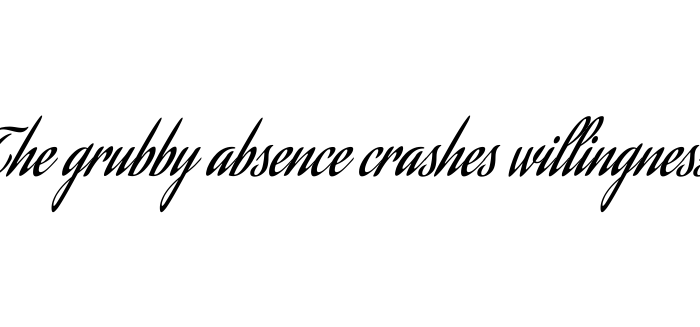

In [68]:
sample_img

In [69]:
# actual label
label_ordering[actual_label]

'AguafinaScript'

In [70]:
# predicted label
label_ordering[np.argmax(softmax(output.predictions[191]), axis = -1)]

'AguafinaScript'